In [44]:
#%pip install tensorflow opencv-python mediapipe scikit-learn sklearn

In [45]:
import numpy as np
import cv2
import os
import mediapipe as mp
import random
import matplotlib.pyplot as plt
import copy
import time
import os
from gtts import gTTS
import pygame
from pygame import mixer
import threading
import pyttsx3

In [46]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [47]:
def mediapipe_detection(input_image, model):
    # Convert image from BGR to RGB
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    # Make prediction
    detection_results = model.process(input_image)
    # Convert image back to BGR
    input_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2BGR)

    return input_image, detection_results

In [48]:
def draw_landmarks(input_image, detection_results):
    # Draw face connections
    mp_drawing.draw_landmarks(input_image, detection_results.face_landmarks, mp_holistic.FACEMESH_TESSELATION)

In [49]:
def draw_styled_landmarks(input_image, detection_results):
    # Set drawing specifications for face connections
    face_points = mp_drawing.DrawingSpec(color=(0,0,0), thickness=1, circle_radius=1) 
    face_lines = mp_drawing.DrawingSpec(color=(255,255,255), thickness=1)

    # Draw face connections
    mp_drawing.draw_landmarks(input_image, detection_results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, face_points, face_lines)


In [50]:
# Extract keypoints into flattened arrays
def extract_keypoints (detection_results):

    face = np.array([[results.x, results.y, results.z]
    for results in detection_results.face_landmarks.landmark]).flatten() if detection_results.face_landmarks else np.zeros(468*3)

    return np.concatenate([face])

In [51]:
# Path to store exported np array
DATA_PATH = os.path.join('EmotionData')

# Gesture that will be detected 
emotions = np.array(['Happy','Sad','Angry','Neutral','Surprised'])

length_frames = 2

In [52]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [53]:
label_map = {label:num for num, label in enumerate(emotions)}

In [54]:
sequences, labels = [], []
for emotion in emotions:
    for frame in np.array(os.listdir(os.path.join(DATA_PATH, emotion))).astype(int):
        window = []
        for frame_num in range(length_frames):
            res = np.load(os.path.join(DATA_PATH, emotion, str(frame), f"{frame_num}.npy"))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[emotion])

In [55]:
x = np.array(sequences)

In [56]:
y = to_categorical(labels).astype(int)

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42, stratify=y)

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard

In [59]:
from datetime import datetime

log_dir = os.path.join('Logs', datetime.now().strftime("%Y%m%d-%H%M%S"))
tb_callback = TensorBoard(log_dir=log_dir)

In [60]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(2, 1404)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False, activation='tanh'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(emotions.shape[0], activation='softmax'))

In [61]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [62]:
model.fit(x_train, y_train, validation_split=0.1, epochs=1000, callbacks=[tb_callback])

Epoch 1/1000
9/9 [==============================] - 5s 160ms/step - loss: 1.6111 - categorical_accuracy: 0.2049 - val_loss: 1.6179 - val_categorical_accuracy: 0.1250
Epoch 2/1000
9/9 [==============================] - 0s 40ms/step - loss: 1.6078 - categorical_accuracy: 0.2297 - val_loss: 1.6283 - val_categorical_accuracy: 0.1250
Epoch 3/1000
9/9 [==============================] - 0s 31ms/step - loss: 1.6092 - categorical_accuracy: 0.2049 - val_loss: 1.6304 - val_categorical_accuracy: 0.1250
Epoch 4/1000
9/9 [==============================] - 0s 32ms/step - loss: 1.6077 - categorical_accuracy: 0.2332 - val_loss: 1.6227 - val_categorical_accuracy: 0.1250
Epoch 5/1000
9/9 [==============================] - 0s 24ms/step - loss: 1.6012 - categorical_accuracy: 0.2580 - val_loss: 1.6313 - val_categorical_accuracy: 0.1250
Epoch 6/1000
9/9 [==============================] - 0s 31ms/step - loss: 1.5969 - categorical_accuracy: 0.2544 - val_loss: 1.6884 - val_categorical_accuracy: 0.1250
Epoch 7/1

In [63]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [66]:
#model.save('My_model_ED.h5')

In [ ]:
from tensorflow.keras.models import load_model

#model = load_model('My_model_ED.h5')

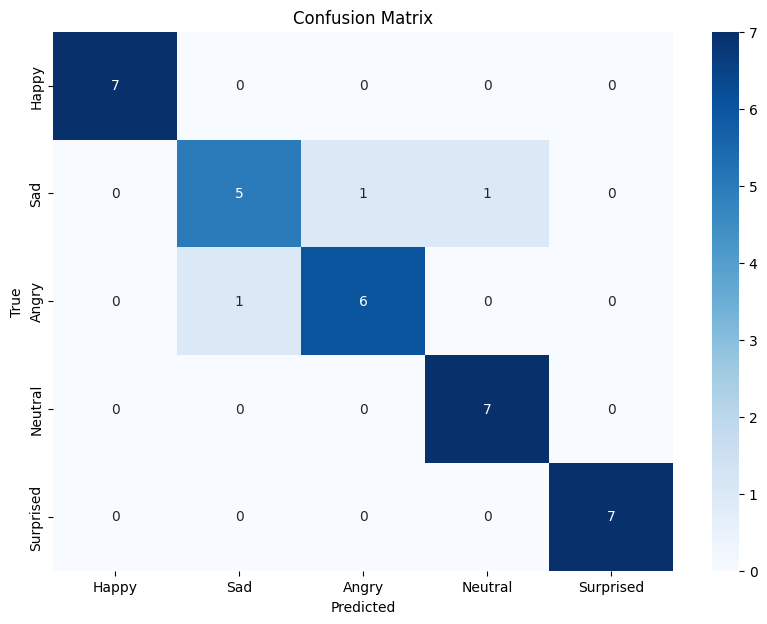

              precision    recall  f1-score   support

       Happy       1.00      1.00      1.00         7
         Sad       0.83      0.71      0.77         7
       Angry       0.86      0.86      0.86         7
     Neutral       0.88      1.00      0.93         7
   Surprised       1.00      1.00      1.00         7

    accuracy                           0.91        35
   macro avg       0.91      0.91      0.91        35
weighted avg       0.91      0.91      0.91        35



In [64]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_test_classes, y_pred_classes, target_names=emotions)
print(report)